In [1]:
import time
import datetime
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import pybullet as p
import pybullet_data

import torch
from torch_cluster import radius_graph, radius
from torch_scatter import scatter

import matplotlib
import matplotlib.pyplot as plt

import edf
from edf.pybullet_env.utils import get_image, axiscreator, img_data_to_pointcloud
from edf.visual_utils import plot_color_and_depth, scatter_plot, scatter_plot_ax, visualize_samples, visualize_sample_cluster
from edf.pybullet_env.env import MugTask

device = 'cpu'
#gpu_idx = 0
#torch.cuda.set_device(gpu_idx)

pybullet build time: Dec  1 2021 18:34:28
/home/hw/anaconda3/envs/SE3_Transporter/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import gzip
import pickle

folder_name = 'demo'
task_name = 'mug_task'
path = f'{folder_name}/{task_name}'

with gzip.open(path + f'/upright.gzip','rb') as f:
    upright_samples = pickle.load(f)

with gzip.open(path + f'/lying.gzip','rb') as f:
    lying_samples = pickle.load(f)

# Learning Pick

In [3]:
from torch import nn
from pytorch3d import transforms

import e3nn.nn
from e3nn import o3
from e3nn.math import soft_one_hot_linspace, soft_unit_step

from edf.utils import preprocess
from edf.models import SE3Transformer, SE3TransformerLight, EnergyModel, QueryTensorField
from edf.mcmc import MH, LangevinMH
from edf.dist import GaussianDistSE3
from edf.layers import QuerySHLayer, TensorFieldLayer


characteristic_length = 0.01

In [4]:
N_query_Q = 1
max_radius_Q = 5.
query_radius_Q = 0.  
field_cutoff_Q = 5.             
ranges_cropped_Q = torch.tensor([[-10., 10.],
                                    [-10., 10.],
                                    [-10., 10.]])
irreps_out_Q = "10x0e + 10x1e + 4x2e + 2x3e"
sh_lmax_descriptor_Q = 3
number_of_basis_descriptor_Q = 10
irrep_normalization_Q = 'norm'


max_radius_K = 2.5
query_radius_K = 0.  
field_cutoff_K = 5.
std_theta_K = 45 / 180 * np.pi
std_X_K = 5.
ranges_cropped_K = torch.tensor([[-21., 21.],
                               [-21., 21.],
                               [-30., -5.]])
irreps_out_K = "10x0e + 10x1e + 4x2e + 2x3e"
irreps_descriptor_K = o3.Irreps(irreps_out_K)
sh_lmax_descriptor_K = 3
number_of_basis_descriptor_K = 10
irrep_normalization_K = 'norm'

In [5]:
seed = 0
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.use_deterministic_algorithms(True)
torch.set_printoptions(precision=4, sci_mode=False)

In [6]:
se3T_Q = SE3TransformerLight(max_neighbor_radius = max_radius_Q, irreps_out=irreps_out_Q)
tensor_field_Q = QueryTensorField(N_query = N_query_Q, field_cutoff = field_cutoff_Q, irreps_input = irreps_out_Q, irreps_output = irreps_out_K,
                                  sh_lmax = sh_lmax_descriptor_Q, number_of_basis = number_of_basis_descriptor_Q,
                                  irrep_normalization = irrep_normalization_Q, path_normalization="element")
query_pos_Q = torch.zeros(N_query_Q, 3, device=device)

se3T_K = SE3TransformerLight(max_neighbor_radius = max_radius_K, irreps_out=irreps_out_K)
irreps_out_K = o3.Irreps(se3T_K.irreps_out)
energy_model_K = EnergyModel(N_query = N_query_Q, query_radius = query_radius_K, field_cutoff = field_cutoff_K,
                           irreps_input = irreps_out_K, irreps_descriptor = irreps_descriptor_K, sh_lmax = sh_lmax_descriptor_K, 
                           number_of_basis = number_of_basis_descriptor_K, ranges = ranges_cropped_K, learnable_query=False)
metropolis_K = MH(ranges_X = ranges_cropped_K, std_theta = std_theta_K, std_X = std_X_K)
langevin_K = LangevinMH(ranges_X = ranges_cropped_K, dt = 0.1, std_theta = 1., std_X = 1.)

In [7]:
tp_pickle_path = "reproducible_pickles/"

#se3T_Q.save_tp(tp_pickle_path + "se3T_Q/")
#tensor_field_Q.save_tp(tp_pickle_path + "tensor_field_Q/")
#se3T_K.save_tp(tp_pickle_path + "se3T_K/")
#energy_model_K.save_tp(tp_pickle_path + "energy_model_K/")
se3T_Q.load_tp(tp_pickle_path + "se3T_Q/")
tensor_field_Q.load_tp(tp_pickle_path + "tensor_field_Q/")
se3T_K.load_tp(tp_pickle_path + "se3T_K/")
energy_model_K.load_tp(tp_pickle_path + "energy_model_K/")

In [8]:
if device == 'cuda':
    se3T_Q = se3T_Q.to(device)
    tensor_field_Q = tensor_field_Q.to(device)
    se3T_K = se3T_K.to(device)
    energy_model_K = energy_model_K.to(device)
    metropolis_K = metropolis_K.to(device)
    langevin_K = langevin_K.to(device)

metropolis_K.get_inv_cdf()
langevin_K.get_inv_cdf()

In [9]:
lr_Q = 5e-3
lr_K = 5e-3
lr_energy_K = 20e-3

optimizer_Q = torch.optim.Adam(list(se3T_Q.parameters()) + list(tensor_field_Q.parameters()), lr=lr_Q, betas=(0.9, 0.98), eps=1e-09, weight_decay=1e-4, amsgrad=True)
optimizer_K = torch.optim.Adam(list(se3T_K.parameters()), lr=lr_K, betas=(0.9, 0.98), eps=1e-09, weight_decay=1e-4, amsgrad=True)
optimizer_energy_K = torch.optim.Adam(list(energy_model_K.parameters()), lr=lr_energy_K, betas=(0.9, 0.98), eps=1e-09, weight_decay=0, amsgrad=True)

#perturb_dist_K = GaussianDistSE3(std_theta = 5 / 180 * np.pi, std_X = 2.5 * 0.1).to(device)
perturb_dist_K = GaussianDistSE3(std_theta = 10 / 180 * np.pi, std_X = 2.5 * 0.2).to(device)

train_samples = upright_samples[:10]
test_samples = upright_samples[10:12] + lying_samples[10:12]

100%|██████████| 299/299 [00:21<00:00, 13.87it/s]


=========Iter 1=========


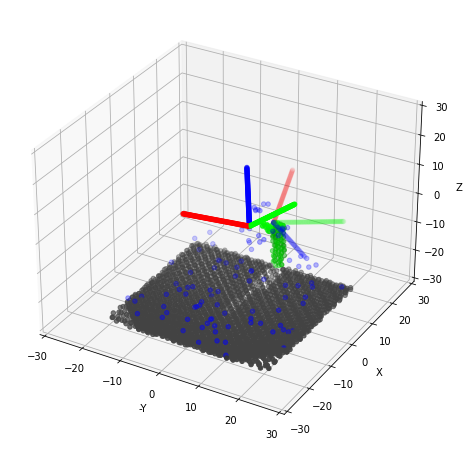

tensor([4.6197, 1.8479, 1.8479, 1.8479, 1.8479, 1.8479, 1.8479, 3.0871, 1.8479,
        1.8479, 1.8479, 1.8479, 1.8479, 1.8503, 1.8479, 3.7454, 1.8479, 1.8479,
        4.1554, 1.8479, 3.3765, 1.8479, 1.8479, 4.0345, 1.8479, 1.8479, 1.8479,
        1.8479, 1.8479, 1.8479, 1.8479, 1.8479, 4.8647, 4.9461, 4.2517, 3.5828,
        1.8479, 1.8479, 1.8479, 3.0655, 1.8479, 3.2241, 3.4178, 3.6394, 1.8479,
        3.1247, 1.8479, 3.1478, 1.8479, 3.3497, 1.8479, 3.3739, 1.8479, 1.8479,
        1.8479, 1.8479, 1.8479, 1.8479, 1.8479, 1.8479, 1.8479, 2.9450, 1.8479,
        1.8479, 4.0918, 3.0271, 3.8448, 1.8479, 1.8479, 1.8479, 1.8479, 1.8479,
        1.8479, 1.8479, 2.8394, 1.8479, 3.7176, 4.3385, 1.8479, 1.8479, 1.8479,
        1.8479, 1.8479, 1.8479, 1.8479, 1.8479, 1.8479, 4.2798, 1.8479, 3.9658,
        1.8479, 6.4427, 1.8479, 1.8479, 1.8479, 1.8479, 1.8479, 5.3774, 1.8479,
        1.8479, 4.3693])
Loss: 2.1914310455322266 || E_pos: 4.619744300842285 || E_neg_min: 1.8479268550872803
Scalar co

100%|██████████| 330/330 [00:16<00:00, 19.51it/s]


=========Iter 50=========


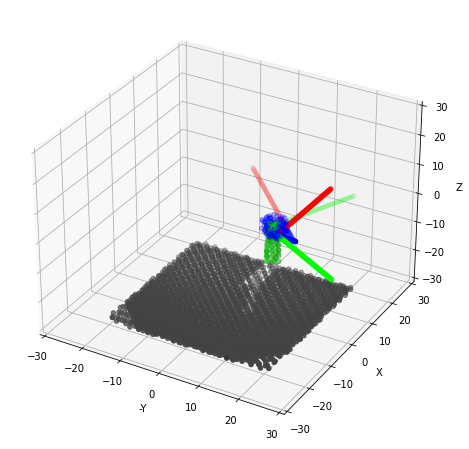

tensor([ 4.1708,  4.6897,  4.7404,  5.9752,  5.6390,  5.2121,  5.4851,  5.8994,
         4.4452,  5.7966,  6.3620,  5.2952,  8.1583,  7.2234,  4.5508,  6.6197,
         3.2576,  4.4687,  5.1695,  4.5109,  7.3988,  4.5281,  7.5267,  3.9717,
         5.9411,  5.1301,  5.9733,  4.8816,  6.3984,  3.7822,  6.1261,  4.9877,
         9.2955,  6.6992,  7.6511,  3.3573, 11.1515,  5.5099,  3.4084,  6.2441,
         6.9234,  5.5796, 13.0271,  4.1609,  7.1413,  5.6797, 11.3942,  3.7430,
         4.2889,  3.1775,  3.5836,  3.9213,  9.8350,  5.4838,  7.8851,  9.6333,
         4.8606,  8.0130,  7.6619,  7.3287,  4.1264,  5.3471,  7.4700,  3.3865,
         8.5241,  5.6569, 11.4895,  4.8325,  4.6715,  6.3573,  5.7512,  7.3445,
         4.3714,  6.0116,  6.3387,  5.8906,  4.7418,  6.3077,  4.4588,  8.3767,
         4.6797,  4.0581, 10.7728,  4.7307,  4.7724,  7.4452,  7.9490,  6.4198,
         5.3531,  7.8983,  5.5735,  6.8063,  6.6606,  4.6270,  3.8735,  6.0754,
         7.8181,  6.1094,  5.4941,  3.54

100%|██████████| 365/365 [00:18<00:00, 19.37it/s]


=========Iter 100=========


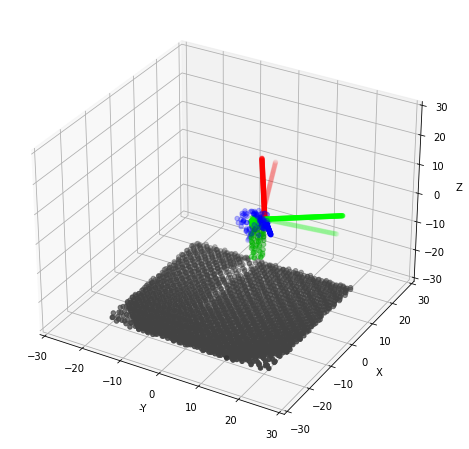

tensor([10.6816, 11.4235, 10.3041,  7.5183,  9.8101, 10.7258,  8.2527, 11.3751,
         9.4635, 10.5186, 11.1101,  8.0236,  6.6066, 10.2331,  7.6059,  9.1322,
         7.8181, 11.0414,  8.3007, 11.0511,  7.6980, 10.1634, 14.6523,  8.6797,
         8.0868, 10.0688, 10.6920,  8.3507,  8.8951, 10.6318, 10.0315,  9.3151,
         7.5722,  8.6831, 10.0148,  7.8098,  8.7194, 10.5830,  6.8699,  8.1814,
         8.0041,  8.7999, 12.0087,  9.4966,  7.9917, 11.2786,  7.1878,  9.8270,
        12.2687,  7.1051,  6.8712,  9.9055,  6.6749,  7.1126,  8.1677, 10.8154,
        10.7828, 10.2172, 10.7789,  9.6773,  7.4744,  8.1621, 10.3643,  8.9141,
         9.3955,  7.4807, 12.0404, 11.0380,  8.6174, 12.0870, 11.2547,  6.0471,
        10.7938, 11.1706,  9.2614,  8.7795,  6.6204,  7.4253,  9.7557, 10.2398,
        10.5861,  7.3022,  9.3264, 12.3144, 10.4983, 11.7130, 14.0717,  7.2833,
         9.5759,  9.4934,  6.9851,  7.4649, 10.5043,  7.9697, 11.9039,  8.3909,
         7.1943, 11.2783,  7.0765, 10.11

100%|██████████| 403/403 [00:21<00:00, 18.54it/s]


=========Iter 150=========


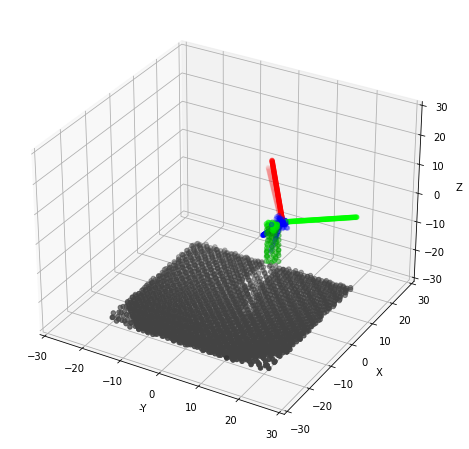

tensor([ 7.8729, 11.0315, 10.3749,  8.2882, 12.4855,  8.0031, 11.5275,  8.2280,
         8.3373, 11.9802, 10.1932,  8.0853,  8.6108,  9.5151, 10.1310,  8.1121,
         9.9493,  9.9651,  7.3171,  9.5028,  7.9608,  7.1389,  9.0626,  7.8729,
         9.6968,  9.2781,  7.3700,  7.4375, 12.5862,  7.7669,  9.1279, 11.8973,
         8.8244,  7.8729,  8.7342, 10.5100,  7.8734,  9.1242, 10.6277,  8.8747,
         7.9895,  9.4562,  9.2722,  7.1699, 10.4695,  6.8825,  9.9351, 10.8821,
        10.7699, 11.7917,  7.8943,  7.5176, 11.2336, 13.4292,  7.6503,  9.2583,
         9.1826,  8.4437,  7.5042,  8.5896,  8.5301,  9.6633,  7.9230,  9.2102,
         6.8335,  6.7062,  9.8603,  8.5644,  8.1135,  7.6405, 10.0063,  8.2811,
         7.8668, 11.2117,  7.9759,  7.3286,  8.8268, 16.4401,  8.0873,  9.8210,
        10.4830, 13.1665,  7.6463, 10.0125,  7.8075, 10.1564,  7.8729,  9.3705,
        10.8414,  6.7393,  6.8773,  8.4058, 12.3309,  8.6815,  8.2740,  7.9652,
         8.3082,  7.3740,  7.8542,  8.36

100%|██████████| 446/446 [00:23<00:00, 19.32it/s]


=========Iter 200=========


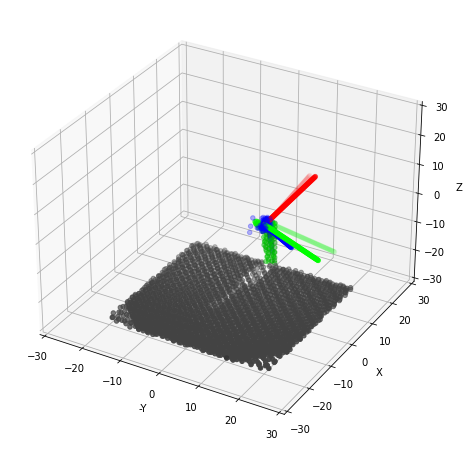

tensor([ 9.7343,  6.7426, 10.0652,  9.8453,  8.3506,  8.7600,  9.3023,  8.1533,
         9.6999,  9.5039,  9.3075,  7.7336,  9.2527,  8.5921,  7.7933,  8.0233,
         9.6251,  9.1024,  9.7240,  8.3845,  9.3567, 11.7172,  8.6223,  9.3697,
         9.5182, 12.3755,  7.9976,  7.0195,  9.3944,  8.9995,  7.3887,  8.2243,
         8.6936,  9.9266,  7.7662, 11.6533, 11.0794,  8.6591, 10.3559,  8.4648,
         7.0049, 15.8501,  8.3424, 10.8938,  7.3934,  7.4164,  8.5504,  7.8147,
         9.4693,  7.8482, 11.9168,  6.9006, 11.9547,  7.5646, 10.4620,  7.2370,
         7.5677, 11.3547,  8.3799, 12.1438, 14.6467,  7.8826,  8.5420,  9.7372,
         9.6701, 10.8060,  6.8272,  7.8720, 11.8072,  9.6780,  8.6116, 11.1928,
         8.2296,  8.5838,  9.2987,  8.5423,  7.8562,  7.9358,  8.3769,  7.5618,
        13.7593, 11.7737, 11.1211, 11.6575,  9.2198, 10.9818,  6.4733,  9.3217,
         8.0499,  9.9921,  9.7775, 10.4595, 16.5219,  9.0124,  7.9038, 12.7922,
        10.7151,  7.8343, 13.2219,  8.45

100%|██████████| 493/493 [00:24<00:00, 20.12it/s]


=========Iter 250=========


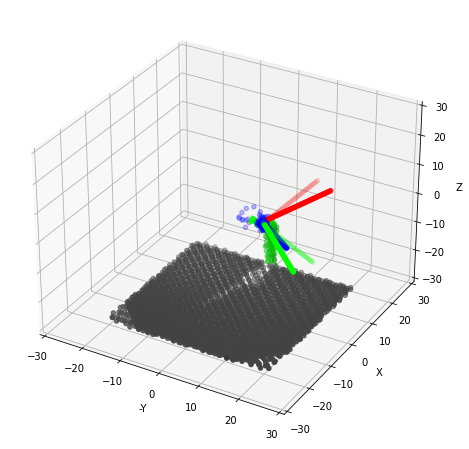

tensor([13.0589, 10.1822, 10.7234,  8.9805,  9.3351,  9.5463,  9.4652, 18.1592,
        19.0503, 11.0006, 11.2044, 11.0855,  9.0919, 13.9721,  8.9669, 10.2239,
        11.3287,  9.3259, 11.3313,  8.9555,  9.5856, 10.8830,  8.5406,  9.2245,
         9.2118, 12.3335, 11.0048,  9.2926, 11.1559,  9.9887, 10.2894,  8.6591,
        10.6706,  9.2300,  9.2250, 11.3556,  9.8740, 10.0687, 11.2099, 16.1452,
        10.0684, 10.4891,  9.6271,  9.0120, 10.1922, 12.3389, 12.7268, 11.6066,
        11.3082,  8.1307,  9.5314, 10.5283, 13.0737,  9.5421, 10.6295, 12.9882,
        16.5461, 10.9224,  8.9328, 12.6845, 10.4297, 11.5725, 13.1095, 10.7540,
        15.7442,  8.6003,  9.9103, 10.6659, 14.5742, 10.4960,  9.3494, 11.8919,
         9.1706, 11.7259, 12.3206, 14.0853, 11.2546,  7.7256,  9.6383, 17.2617,
        10.3016,  8.7488, 15.9122, 11.0596, 11.9694, 11.2567,  9.2096,  8.5830,
        10.2699, 11.1535, 11.3953,  9.6346, 12.1091, 14.3527,  8.8473, 10.0980,
         9.7833, 10.4544, 12.2652,  8.85

100%|██████████| 545/545 [00:28<00:00, 19.36it/s]


=========Iter 300=========


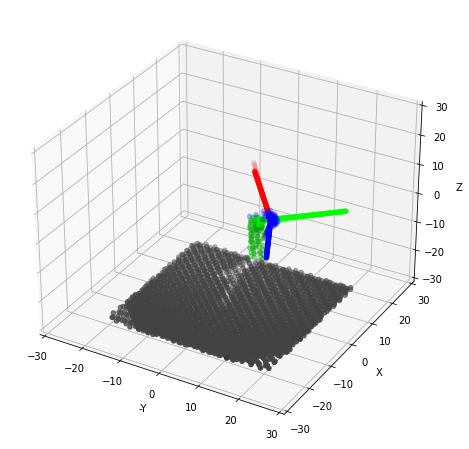

tensor([10.7124, 10.5348, 10.4344, 10.8669, 14.4514,  8.3831,  9.2953, 12.7206,
         9.4115,  7.9937,  9.2568,  9.8555, 11.0641,  8.3718,  9.8612,  9.7033,
        11.3457, 10.1177, 13.0839,  9.4186, 17.6760,  8.3332, 13.9857, 12.0616,
        12.2160,  8.4610, 12.5479, 10.0524,  9.8117, 14.1050,  9.2031, 14.5071,
        10.4857,  7.9521, 12.1779,  8.2012, 10.5229,  7.4013,  8.2355, 10.6035,
        10.6572, 12.2355, 11.6880,  9.2145, 12.8336,  7.9287, 13.1556,  9.8535,
         9.2723, 11.0728, 15.4991, 10.6396, 12.0440, 11.4724, 14.5546, 10.2114,
         8.3747,  9.2098, 10.7287, 13.7632, 17.4750,  9.1989,  8.5552,  8.7342,
        10.1995, 10.7932,  8.7105,  7.8935,  9.8296, 12.7270, 10.5949, 10.1424,
         8.2863,  8.5041,  9.6984, 13.1318,  8.1900,  9.0063,  7.8548, 14.3185,
        10.3301,  8.5203,  9.2913,  8.6630, 11.3426,  9.6815, 12.4610, 11.2418,
         8.2110, 10.7878, 10.4834, 10.4255, 13.4065,  8.3848, 10.2996,  7.3771,
         9.0766, 11.7552, 11.4918,  9.69

100%|██████████| 603/603 [00:32<00:00, 18.66it/s]


=========Iter 350=========


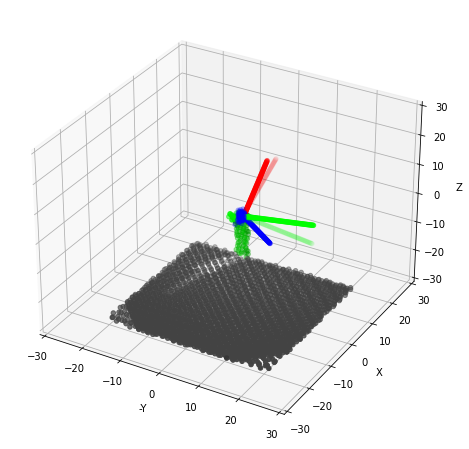

tensor([ 9.5249, 10.6146,  8.2353, 11.1774, 12.2077, 10.6890,  7.9283,  9.1127,
        11.4313,  8.1097, 10.1116, 12.3234,  7.8457,  8.0425,  8.2381, 11.7164,
        12.0769,  9.0377,  8.9669, 12.0472, 10.6458,  8.9235,  8.9645,  7.9987,
         9.9882, 10.5182,  8.9359,  7.6828,  9.8391,  7.7329,  7.7859,  9.6512,
         8.5153,  7.4282,  7.5069,  9.0976,  8.0532,  9.9427,  8.1499,  8.1778,
         8.0984,  7.7158,  9.9100,  8.1340,  8.4593,  7.1321, 10.0307,  8.3395,
        10.1664,  8.5469,  9.3311,  8.5722,  7.4656,  9.4090, 10.3566, 12.0830,
         7.6875, 10.0338,  9.9373,  8.6047,  8.4325,  7.3336, 11.5384,  7.6126,
        13.5938, 10.0700, 10.6727, 10.0709,  9.3971,  9.3709,  8.2747,  8.4848,
         9.2345,  8.7895,  9.3561,  8.5702,  9.2829,  8.3794, 10.9778,  9.3022,
         9.3639, 11.3781, 13.7442, 12.0713,  7.5616,  8.4040, 12.7414, 12.4517,
        10.1856,  9.3327, 10.0641,  8.3602, 11.2168,  9.5596,  9.6291, 12.1381,
        13.2015,  7.9506,  9.6230, 11.36

100%|██████████| 666/666 [00:34<00:00, 19.16it/s]


=========Iter 400=========


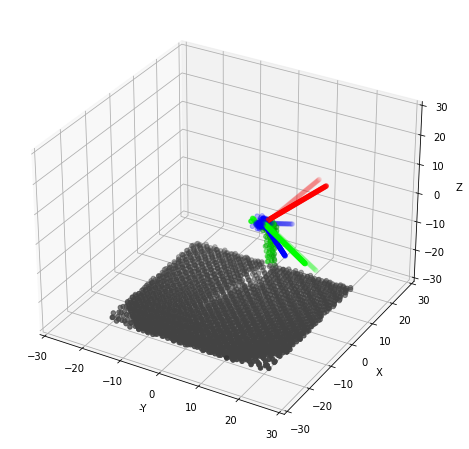

tensor([12.1368, 10.0130, 11.0930, 10.5517, 10.2938, 13.7237,  8.6465, 11.3266,
        14.5574,  9.1901, 10.2960, 10.1680,  9.8869,  9.6052,  8.9204, 11.0279,
        10.1993,  9.2369,  9.3022,  9.6074, 10.1365,  8.5518, 15.4487, 11.2700,
         9.8086, 12.8228, 11.3184,  8.9727, 10.2797, 16.5406, 12.6524,  9.3217,
        10.9341,  8.6217, 14.4204, 12.7752, 10.9545, 13.1047,  9.8442, 10.8526,
        13.1647,  8.6894, 10.8642,  9.1365,  8.6627,  7.9792, 14.1567, 13.6926,
        10.7476, 11.9763,  8.6853,  8.8864, 11.5772, 11.4214, 11.9494, 13.6327,
        10.8864,  9.6186, 12.1510,  8.7258, 14.9741,  8.7912,  9.1270, 10.5242,
        10.6969,  8.6136,  8.8970,  9.7197, 11.6485, 10.0852,  8.0235,  8.0411,
        11.2061, 10.8602,  8.6471,  8.5041, 11.0475, 12.0198,  8.8556,  9.9022,
        11.8524, 12.1084,  9.0423, 10.5420, 11.5832, 12.6670, 14.2116,  9.1397,
        11.6609, 15.8832,  9.4220,  8.7717,  9.8232,  9.1089,  8.5557, 12.3553,
        11.5238, 12.8064, 10.4194, 13.64

100%|██████████| 736/736 [00:38<00:00, 19.10it/s]


=========Iter 450=========


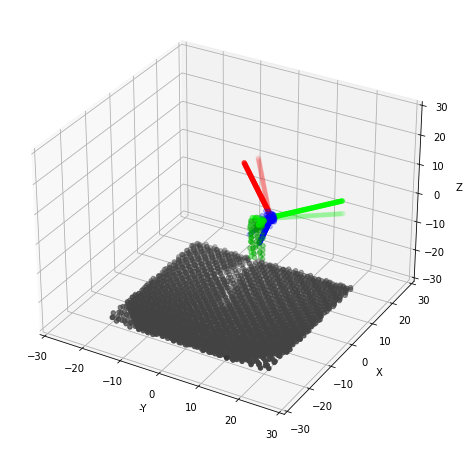

tensor([ 8.5565,  7.4384, 11.3124, 11.2730, 14.2547, 11.8627,  9.9016,  7.7704,
        19.4464, 12.8183,  8.6980, 10.5954,  9.6173,  9.3977, 12.1410,  8.8746,
        10.9739, 12.3448,  9.0855,  9.8104,  7.7824, 10.1007,  9.9297,  9.1664,
        12.3117, 10.8207, 10.6766, 10.1988, 14.2590,  9.3523,  8.9401, 12.9444,
         8.5060, 11.2503,  9.8093,  7.3323,  8.7254,  9.8265,  9.2141,  8.9297,
         8.5047,  8.8269,  9.6537,  9.2365,  9.4934,  9.2687,  8.9123, 11.2555,
        13.0741,  9.5982, 10.8377,  9.2847, 14.4699, 11.0758, 11.6511,  9.9705,
         9.5464,  8.8155, 13.7588,  8.8217,  7.9009, 11.5055, 11.2281,  7.3750,
         8.4443,  8.5578,  8.5590,  8.4190, 10.8746,  8.5154, 10.8325,  8.4421,
         8.5137, 15.0298,  8.0991,  9.4216,  8.8957,  9.2347, 12.5287,  9.0262,
         9.5993, 10.0760, 13.0129,  7.5568,  9.8910, 11.0944, 11.1937,  8.6404,
        10.7360,  9.0134, 15.0303, 10.0954,  9.0443, 13.6980,  9.8061, 10.2661,
         9.9717,  9.7154, 12.6117,  9.64

100%|██████████| 814/814 [00:42<00:00, 19.00it/s]


=========Iter 500=========


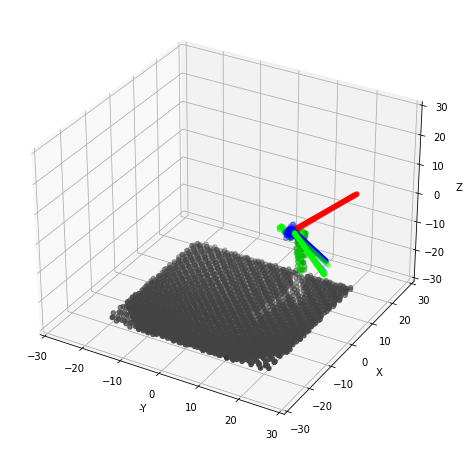

tensor([ 7.9575, 10.0250,  7.9674,  8.3548,  9.5317,  8.5026, 10.2749,  7.4607,
         8.1843, 10.6351, 10.5504, 12.3153, 10.4372,  7.2302,  7.8959, 10.1671,
         8.5950,  9.3034,  8.4530,  8.1174, 11.0298,  8.0382,  9.4449,  8.7379,
        12.4853,  9.0567,  7.5211,  9.3188, 10.5982,  8.6539,  8.7199,  7.4930,
        13.9696,  9.5258,  9.5279,  7.1126,  8.1359,  7.1918, 12.5757,  8.6994,
        11.6981,  8.7147,  8.0600, 10.5801,  7.5438,  9.0023,  8.8781,  9.9041,
         8.5150,  8.1059, 10.4446, 11.3149, 10.8988,  8.1053, 13.1074, 12.8518,
         8.3630, 10.8151, 10.2508,  7.4664,  7.4480, 10.0544,  8.0295,  7.9411,
         8.5873,  9.9235,  9.5289,  9.2734,  8.1985,  9.1619,  9.7196,  9.2804,
         9.2079,  8.4511, 10.7245, 10.3702,  9.8884,  8.9162, 10.8301,  7.5974,
         7.4682,  9.5258,  7.9849,  9.7140,  9.5617,  9.4115, 11.6236,  8.5792,
         8.3399,  7.7136, 11.2140,  9.5020,  8.3089, 10.2732,  7.7800,  8.3386,
        14.2194, 10.6862,  8.1012,  9.22

In [10]:
save_checkpoint = True
PATH = f'checkpoint/train_place_reproducible/{datetime.datetime.now().strftime("%b_%d_%Y__%H_%M_%S")}'
if save_checkpoint:
    if os.path.exists(PATH) is False:
        os.makedirs(PATH)

    torch.save({'se3T_K_state_dict': se3T_K.state_dict(),
                'energy_model_K_state_dict': energy_model_K.state_dict(),
                'se3T_Q_state_dict': se3T_Q.state_dict(),
                'tensor_field_Q_state_dict': tensor_field_Q.state_dict(),
                }, PATH + f'/model_place_iter_{0}.pt')


max_epochs = 50
max_iter = len(train_samples) * max_epochs

iter = 0
for epoch in range(1, max_epochs+1):
    train_sample_indices = list(range(10))
    np.random.shuffle(train_sample_indices)
    for train_sample_idx in train_sample_indices:
        iter += 1
        sample = train_samples[train_sample_idx]

        t1 = time.time()
        temperature = 1.

        color_unprocessed_Q = sample['color_pick']
        color_unprocessed_K = sample['color_place']
        sample = preprocess(sample, characteristic_length, pick_and_place=True)

        coord_Q, color_Q, (xlim_Q, ylim_Q, zlim_Q) = sample['coord_Q'], sample['color_Q'], sample['ranges_Q']
        X_sg_Q, R_sg_Q = sample['grasp_Q'][0], sample['grasp_Q'][1]
        data_transform_Q = sample['data_transform_Q']

        coord_K, color_K, (xlim_K, ylim_K, zlim_K) = sample['coord_K'], sample['color_K'], sample['ranges_K']
        X_sdg_K, R_sdg_K = sample['grasp_K'][0], sample['grasp_K'][1]
        data_transform_K = sample['data_transform_K']


        ##### Prepare input
        X_sg_Q = torch.tensor(X_sg_Q, dtype=torch.float32).unsqueeze(0).to(device) # (1, 3)
        R_sg_Q = torch.tensor(R_sg_Q, dtype=torch.float32).unsqueeze(0).to(device) # (1, 3, 3)
        target_pos_K = torch.tensor(X_sdg_K, dtype=torch.float32).unsqueeze(0).to(device) # (1, 3)
        target_orn_K = torch.tensor(R_sdg_K, dtype=torch.float32).unsqueeze(0).to(device) # (1, 3, 3)

        feature_Q = torch.tensor(color_Q, dtype=torch.float32)
        pos_Q = torch.tensor(coord_Q, dtype=torch.float32)
        in_range_cropped_idx_Q = (((pos_Q[:] > ranges_cropped_Q[:,0]) * (pos_Q[:] < ranges_cropped_Q[:,1])).sum(dim=-1) == 3).nonzero().squeeze(-1)
        pos_Q = pos_Q[in_range_cropped_idx_Q].to(device)
        feature_Q = feature_Q[in_range_cropped_idx_Q].to(device)

        feature_K = torch.tensor(color_K, dtype=torch.float32)
        pos_K = torch.tensor(coord_K, dtype=torch.float32)
        in_range_cropped_idx_K = (((pos_K[:] > ranges_cropped_K[:,0]) * (pos_K[:] < ranges_cropped_K[:,1])).sum(dim=-1) == 3).nonzero().squeeze(-1)
        pos_K = pos_K[in_range_cropped_idx_K].to(device)
        feature_K = feature_K[in_range_cropped_idx_K].to(device)

        inputs_Q = {'feature': feature_Q, 'pos': pos_Q, 'edge': None, 'max_neighbor_radius': max_radius_Q}


        ##### Get Query Feature
        optimizer_Q.zero_grad()
        outputs_Q = se3T_Q(inputs_Q)
        outputs_Q = tensor_field_Q({'feature':outputs_Q['feature'], 'pos':outputs_Q['pos'], 'query_pos':query_pos_Q.unsqueeze(0)})
        assert outputs_Q['n_neighbor'].item() > 0
        query_feature_Q = outputs_Q['field'].squeeze(0)

        inputs_K = {'feature': feature_K, 'pos': pos_K, 'edge': None, 'max_neighbor_radius': max_radius_K}
        target_T_sp = torch.cat([transforms.matrix_to_quaternion(target_orn_K), target_pos_K], dim=-1)
        target_T_sp = perturb_dist_K.propose(target_T_sp)
        target_q_sp, target_X_sp = target_T_sp[...,:4], target_T_sp[...,4:]
        target_R_sp = transforms.quaternion_to_matrix(target_q_sp)


        ##### MCMC
        N_transforms = 100
        mh_iter = int( 1000 * np.exp(iter / max_iter) )
        langevin_iter = int( 300 * np.exp(iter / max_iter) )
        if iter % 50 == 0 or iter == 1 or save_checkpoint is False:
            pbar = True
        else:
            pbar = False

        optimizer_K.zero_grad()
        optimizer_energy_K.zero_grad()
        outputs_K = se3T_K(inputs_K)
        outputs_K['query_feature'] = query_feature_Q
        log_P_K = lambda T: -energy_model_K(outputs_K, T, temperature = temperature, learning = False)

        T_seed = target_T_sp.repeat(N_transforms,1)
        t_mcmc_begin = time.time()
        samples = metropolis_K.forward(log_P_K, max_iter = mh_iter, T_seed = T_seed, pbar=pbar)
        Ts_K = samples['Ts']
        As_K = samples['As']
        samples = langevin_K.forward(log_P_K, max_iter = langevin_iter, optim = optimizer_energy_K, T_seed = Ts_K[-1], pbar=pbar)
        Ts_K = torch.cat([Ts_K, samples['Ts']], dim=0)
        As_K = torch.cat([As_K, samples['As']], dim=0)
        t_mcmc_end = time.time()

        N_rejected_K = (~As_K).sum(dim=0)
        N_rejected_K_langevin = (~samples['As']).sum(dim=0)
        Ts_K = Ts_K[-1:].reshape(-1,7)
        Ts_K = torch.cat([target_T_sp , Ts_K], dim=0)


        ##### Calculate energy and learn
        optimizer_energy_K.zero_grad()
        E_K = energy_model_K(outputs_K, Ts_K, temperature = temperature, learning = True)
        E_pos_K = E_K[...,0]
        E_neg_K = E_K[...,1:].mean(dim=-1)

        Loss_K = E_pos_K - E_neg_K
        Loss_K.backward()
        optimizer_Q.step()
        optimizer_K.step()
        optimizer_energy_K.step()

        best_T_sp_idx = E_K[...,1:].detach().argmin().item() + 1
        best_T_sp = Ts_K[best_T_sp_idx]
        best_R_sp, best_X_sp = transforms.quaternion_to_matrix(best_T_sp[...,:4]), best_T_sp[...,4:]

        ##### Visualize
        t2 = time.time()
        if iter % 50 == 0 or iter == 1 or save_checkpoint is False:
            print(f"=========Iter {iter}=========")
            query_attn_K = (torch.softmax(energy_model_K.query_attention.detach(), dim=-1) ** 0.5).unsqueeze(-1).cpu().numpy()
            
            coord_query_K = energy_model_K.transform_query_points(best_T_sp).detach().cpu().numpy()
            color_query_K = torch.tensor([0.,0.,1.]).repeat(len(coord_query_K),1).cpu().numpy()
            color_query_K = np.concatenate([color_query_K, query_attn_K], axis=-1)
            frame_info_best = {'frame': best_R_sp.cpu().numpy(),
                            'origin': best_X_sp.cpu().numpy(), 
                            'alpha': 1.,
                            'pointcloud': (coord_query_K, color_query_K)
                            }

            coord_query_K = energy_model_K.transform_query_points(target_T_sp).detach().cpu().numpy().squeeze(0)
            color_query_K = torch.tensor([0.,0.,1.]).repeat(len(coord_query_K),1).cpu().numpy()
            color_query_K = np.concatenate([color_query_K, query_attn_K], axis=-1)
            frame_info_target = {'frame': target_R_sp.squeeze(0).cpu().numpy(),
                            'origin': target_X_sp.squeeze(0).cpu().numpy(), 
                            'alpha': 0.1,
                            'pointcloud': (coord_query_K, color_query_K)
                            }

            world_origin_K = np.array([0., 0., -16.])
            frame_info_world = {'frame': np.eye(3),
                            'origin': world_origin_K,
                            'alpha': 0.,
                            'pointcloud': (Ts_K.detach().cpu().numpy()[1:,4:], torch.tensor([0.,0.,1.,0.5]).repeat(N_transforms,1).numpy())
                            }

            color_unprocessed_alpha_K = np.concatenate([color_unprocessed_K, np.ones((len(color_unprocessed_K),1), dtype=int)], axis=-1)
            scatter_plot(coord_K[in_range_cropped_idx_K], color_unprocessed_alpha_K[in_range_cropped_idx_K], (xlim_K, ylim_K, zlim_K), frame_infos = [frame_info_best, frame_info_target, frame_info_world], figsize = (8, 8))
            print(E_K.detach())
            print(f"Loss: {Loss_K.item()} || E_pos: {E_pos_K.detach().cpu()} || E_neg_min: {E_K[...,1:].min(dim=-1)[0].detach().cpu()}")
            print(f"Scalar coeff: {np.exp(energy_model_K.scalar_coeff.item())} || Vector coeff:{np.exp(energy_model_K.vector_coeff.item())}")
            print(f"Time: {t2-t1}")
            print(f"MCMC Time: {t_mcmc_end - t_mcmc_begin}")
            #print(f"Mean Reject ratio: {(N_rejected_K.type(torch.float32)/mh_iter).mean()}")
            print(f"Mean Langevin Reject ratio: {(N_rejected_K_langevin.type(torch.float32)/langevin_iter).mean()}")
            print("===============================")

            if save_checkpoint:
                if os.path.exists(PATH) is False:
                    os.makedirs(PATH)

                torch.save({'se3T_K_state_dict': se3T_K.state_dict(),
                            'energy_model_K_state_dict': energy_model_K.state_dict(),
                            'se3T_Q_state_dict': se3T_Q.state_dict(),
                            'tensor_field_Q_state_dict': tensor_field_Q.state_dict(),
                            }, PATH + f'/model_place_iter_{iter}.pt')
        else:
            print(f"MCMC Time: {t_mcmc_end - t_mcmc_begin} || Mean Langevin Reject ratio: {(N_rejected_K_langevin.type(torch.float32)/langevin_iter).mean()} || Loss: {Loss_K.item()}")
